### Reichel Larez 344474
### Octavio Revetria 232745

# Tarea 2 - Taller de Deep Learning

**Fecha de entrega: 16/11/2025**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su capacidad para aplicar modelos de redes neuronales recurrentes (RNN/LSTM/GRU) en un problema de clasificación de secuencias. En particular, vamos a evaluar la performance de sus modelos en la clasificación de ritmos cardíacos usando datos de electrocardiograma (ECG).

**Dataset**

El dataset a ser utilizado es el [Heartbeat Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat). Este dataset contiene señales de ECG segmentadas, donde cada segmento corresponde a un latido del corazón. Cada segmento ya está preprocesado y categorizado en una de las siguientes clases:

- **N**: Normal (0)
- **S**: Arritmia supraventricular (1)
- **V**: Arritmia ventricular (2)
- **F**: Latido fusionado (3)
- **Q**: Latido desconocido (4)

Los archivos del dataset que deben utilizar son:

- **mitbih_train.csv**: Datos de entrenamiento.
- **mitbih_test.csv**: Datos de prueba.

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema, así como las técnicas y herramientas que quieran usar. Se recomienda el uso de Google Colab para simplificar el acceso a recursos de GPU, aunque pueden trabajar en sus propias máquinas si lo prefieren. La entrega debe realizarse en formato .ipynb (Jupyter Notebook) **con las celdas ya ejecutadas**.

**Restricciones**

- No se permite utilizar modelos pre-entrenados; cada modelo debe ser implementado desde cero.
- Deben utilizar al menos un modelo basado en RNN (por ejemplo, LSTM o GRU).
- Es necesario realizar un **análisis exploratorio de los datos**, que incluya una descripción de las señales ECG, el balanceo de clases y cualquier limpieza o transformación necesaria de los datos.
- Las decisiones sobre el preprocesamiento de las señales (como normalización, segmentación, etc.) deben estar fundamentadas en una exploración inicial del dataset y explicadas en el notebook.

**Reporte**

Se requiere que reporten las siguientes métricas: accuracy, precision, recall y F1-score para la evaluación del modelo. Además, se espera ver una evolución clara del modelo durante el entrenamiento, que incluya logs y gráficas de las métricas tanto para los datos de entrenamiento como de validación.

**Evidencia de Experimentos**

Deben proporcionar evidencia de la ejecución de experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:

- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

## 1. Configuración

Contábamos con distintos entornos de ejecución, tanto en CPU local como en GPU. El entrenamiento en CPU resultaba demasiado lento, por lo que optamos por ejecutar el modelo también en Google Colab para aprovechar la aceleración por GPU. Para ello, incorporamos una configuración capaz de detectar automáticamente el entorno de ejecución (Colab vs. local) y ajustar los parámetros y rutas correspondientes.

### 1.1 Imports y detección de entorno

In [94]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
)
from sklearn.utils.class_weight import compute_class_weight

sns.set(style="whitegrid")

# Reproducibilidad básica
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print("Seed fijada en 42")


try:
    from google.colab import drive  # type: ignore
    IN_COLAB = True
    print("Ejecutando en Google Colab")
except ImportError:
    IN_COLAB = False
    print("Ejecutando en entorno local")


if IN_COLAB:
    # Ajustar esta ruta a tu Drive si es necesario
    drive.mount("/content/drive")
    BASE_DIR = "/content/drive/MyDrive/Tarea_2_TDL/RNN"
else:
    BASE_DIR = os.getcwd()

DATA_DIR = os.path.join(BASE_DIR, "data")

data_files = {
    "train": os.path.join(DATA_DIR, "mitbih_train.csv"),
    "test": os.path.join(DATA_DIR, "mitbih_test.csv"),
}

print("\nRutas de datos:")
for k, v in data_files.items():
    print(f"{k}: {v}")

Seed fijada en 42
Ejecutando en Google Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Rutas de datos:
train: /content/drive/MyDrive/Tarea_2_TDL/RNN/data/mitbih_train.csv
test: /content/drive/MyDrive/Tarea_2_TDL/RNN/data/mitbih_test.csv


## 2. Exploración del dataset

In [95]:
df_train = pd.read_csv(data_files["train"], header=None)
df_test  = pd.read_csv(data_files["test"], header=None)

# Última columna = etiqueta
X_train_raw = df_train.iloc[:, :-1].values.astype(np.float32)
y_train     = df_train.iloc[:, -1].values.astype(int)

X_test_raw  = df_test.iloc[:, :-1].values.astype(np.float32)
y_test      = df_test.iloc[:, -1].values.astype(int)

print(f"Total ECGs (train + test): {len(df_train) + len(df_test)}")
print(f"Total muestras train: {len(df_train)}")
print(f"Total muestras test : {len(df_test)}")

print(f"\nLongitud de cada latido (número de puntos): {X_train_raw.shape[1]}")
print(f"Rango de valores en train: [{X_train_raw.min():.3f}, {X_train_raw.max():.3f}]")
print(f"Media global (train): {X_train_raw.mean():.3f}")
print(f"Std global  (train): {X_train_raw.std():.3f}")

Total ECGs (train + test): 109446
Total muestras train: 87554
Total muestras test : 21892

Longitud de cada latido (número de puntos): 187
Rango de valores en train: [0.000, 1.000]
Media global (train): 0.174
Std global  (train): 0.226


### 2.1 Set de validación

In [96]:
X_train_full = X_train_raw
y_train_full = y_train

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=y_train_full,
)

print("Tamaños después del split train/valid:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val  : {X_val.shape}, y_val  : {y_val.shape}")
print(f"X_test : {X_test_raw.shape}, y_test: {y_test.shape}")

Tamaños después del split train/valid:
X_train: (70043, 187), y_train: (70043,)
X_val  : (17511, 187), y_val  : (17511,)
X_test : (21892, 187), y_test: (21892,)


### 2.2 Análisis profundo del dataset

Un análisis exploratorio profundo es crucial para entender las características de las señales ECG y tomar decisiones informadas sobre el preprocesamiento y arquitectura del modelo.

In [98]:
class_names = {
    0: "N (Normal)",
    1: "S (Supraventricular)",
    2: "V (Ventricular)",
    3: "F (Fusión)",
    4: "Q (Desconocido)",
}

# Conteo de clases en train (antes del split) y test
train_counts = pd.Series(y_train_full).value_counts().sort_index()
test_counts  = pd.Series(y_test).value_counts().sort_index()

print("---- Conteo por clase en datos de entrenamiento (antes de split) ----")
for cls, count in train_counts.items():
    percentage = (count / len(y_train_full)) * 100
    print(f"Clase {cls} ({class_names[cls]}): {count:>6} muestras ({percentage:>5.1f}%)")

print("\n---- Conteo por clase en datos de test ----")
for cls, count in test_counts.items():
    percentage = (count / len(y_test)) * 100
    print(f"Clase {cls} ({class_names[cls]}): {count:>6} muestras ({percentage:>5.1f}%)")

# Desbalance de clases
max_count = train_counts.max()
min_count = train_counts.min()
imbalance_ratio = max_count / min_count

print("\n---- Análisis de desbalance de clases ----")
print(f"Clase más frecuente: {max_count} muestras")
print(f"Clase menos frecuente: {min_count} muestras")
print(f"Ratio de desbalance aproximado: {imbalance_ratio:.1f}:1")

---- Conteo por clase en datos de entrenamiento (antes de split) ----
Clase 0 (N (Normal)):  72471 muestras ( 82.8%)
Clase 1 (S (Supraventricular)):   2223 muestras (  2.5%)
Clase 2 (V (Ventricular)):   5788 muestras (  6.6%)
Clase 3 (F (Fusión)):    641 muestras (  0.7%)
Clase 4 (Q (Desconocido)):   6431 muestras (  7.3%)

---- Conteo por clase en datos de test ----
Clase 0 (N (Normal)):  18118 muestras ( 82.8%)
Clase 1 (S (Supraventricular)):    556 muestras (  2.5%)
Clase 2 (V (Ventricular)):   1448 muestras (  6.6%)
Clase 3 (F (Fusión)):    162 muestras (  0.7%)
Clase 4 (Q (Desconocido)):   1608 muestras (  7.3%)

---- Análisis de desbalance de clases ----
Clase más frecuente: 72471 muestras
Clase menos frecuente: 641 muestras
Ratio de desbalance aproximado: 113.1:1


#### **Distribución de las clases**

/tmp/ipython-input-1321497178.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([class_names[c] for c in class_counts_train["class"]])


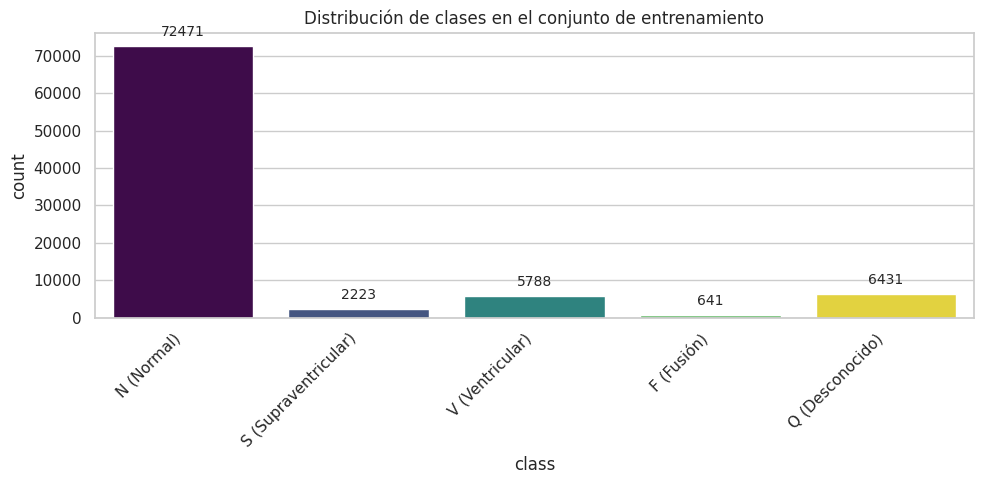

In [99]:
class_counts_train = train_counts.reset_index()
class_counts_train.columns = ["class", "count"]

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=class_counts_train,
    x="class",
    y="count",
    hue="class",
    palette="viridis",
    legend=False,
)

plt.title("Distribución de clases en el conjunto de entrenamiento")
ax.set_xticklabels([class_names[c] for c in class_counts_train["class"]])
plt.xticks(rotation=45, ha="right")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{int(height)}",
        (p.get_x() + p.get_width() / 2.0, height),
        ha="center",
        va="bottom",
        fontsize=10,
        xytext=(0, 5),
        textcoords="offset points",
    )

plt.tight_layout()
plt.show()

#### Análisis estadístico


Estadísticas por clase (usando train completo antes del split):
--------------------------------------------------------------------------------

Clase 0 (N (Normal)):
  Número de muestras              : 72471
  Rango de valores                : [0.000, 1.000]
  Media global de amplitud        : 0.162
  Desvío estándar global          : 0.218
  Varianza promedio por timestep  : 0.168

Clase 1 (S (Supraventricular)):
  Número de muestras              : 2223
  Rango de valores                : [0.000, 1.000]
  Media global de amplitud        : 0.195
  Desvío estándar global          : 0.215
  Varianza promedio por timestep  : 0.162

Clase 2 (V (Ventricular)):
  Número de muestras              : 5788
  Rango de valores                : [0.000, 1.000]
  Media global de amplitud        : 0.244
  Desvío estándar global          : 0.262
  Varianza promedio por timestep  : 0.212

Clase 3 (F (Fusión)):
  Número de muestras              : 641
  Rango de valores                : [0.000, 1.000]
  

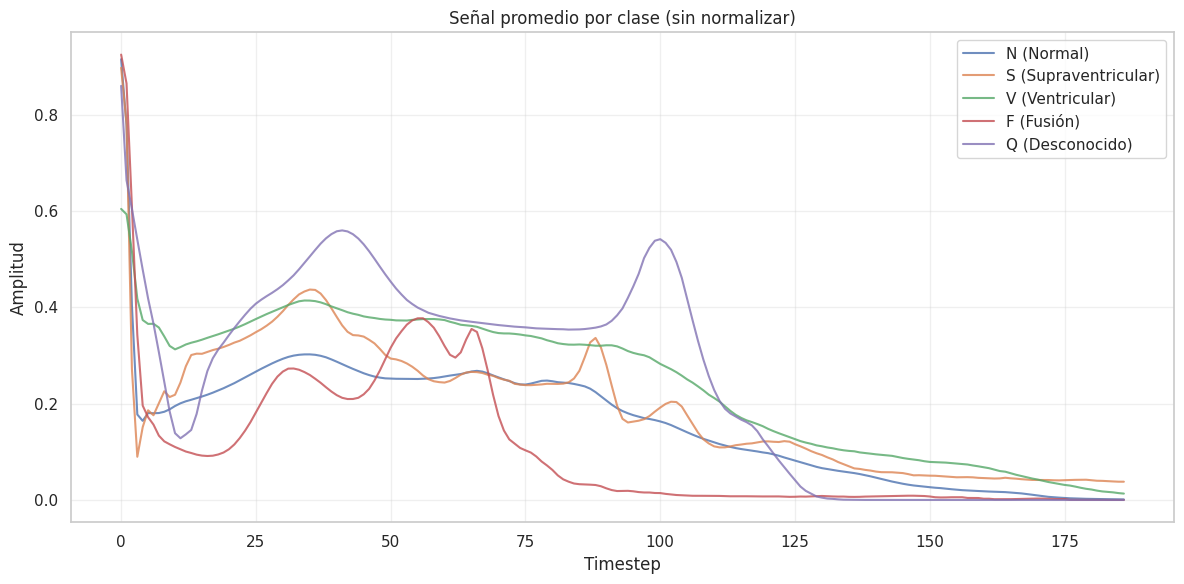

In [100]:
print("Estadísticas por clase (usando train completo antes del split):")
print("-" * 80)

for cls in range(5):
    class_data = X_train_raw[y_train_full == cls]
    mean_signal = class_data.mean(axis=0)
    std_signal  = class_data.std(axis=0)

    print(f"\nClase {cls} ({class_names[cls]}):")
    print(f"  Número de muestras              : {len(class_data)}")
    print(f"  Rango de valores                : [{class_data.min():.3f}, {class_data.max():.3f}]")
    print(f"  Media global de amplitud        : {class_data.mean():.3f}")
    print(f"  Desvío estándar global          : {class_data.std():.3f}")
    print(f"  Varianza promedio por timestep  : {std_signal.mean():.3f}")

# (Opcional) Visualizamos la media por clase
plt.figure(figsize=(12, 6))
for cls in range(5):
    class_data = X_train_raw[y_train_full == cls]
    mean_signal = class_data.mean(axis=0)
    plt.plot(mean_signal, label=class_names[cls], alpha=0.8)

plt.title("Señal promedio por clase (sin normalizar)")
plt.xlabel("Timestep")
plt.ylabel("Amplitud")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### Ejemplos por clase SIN NORMALIZAR

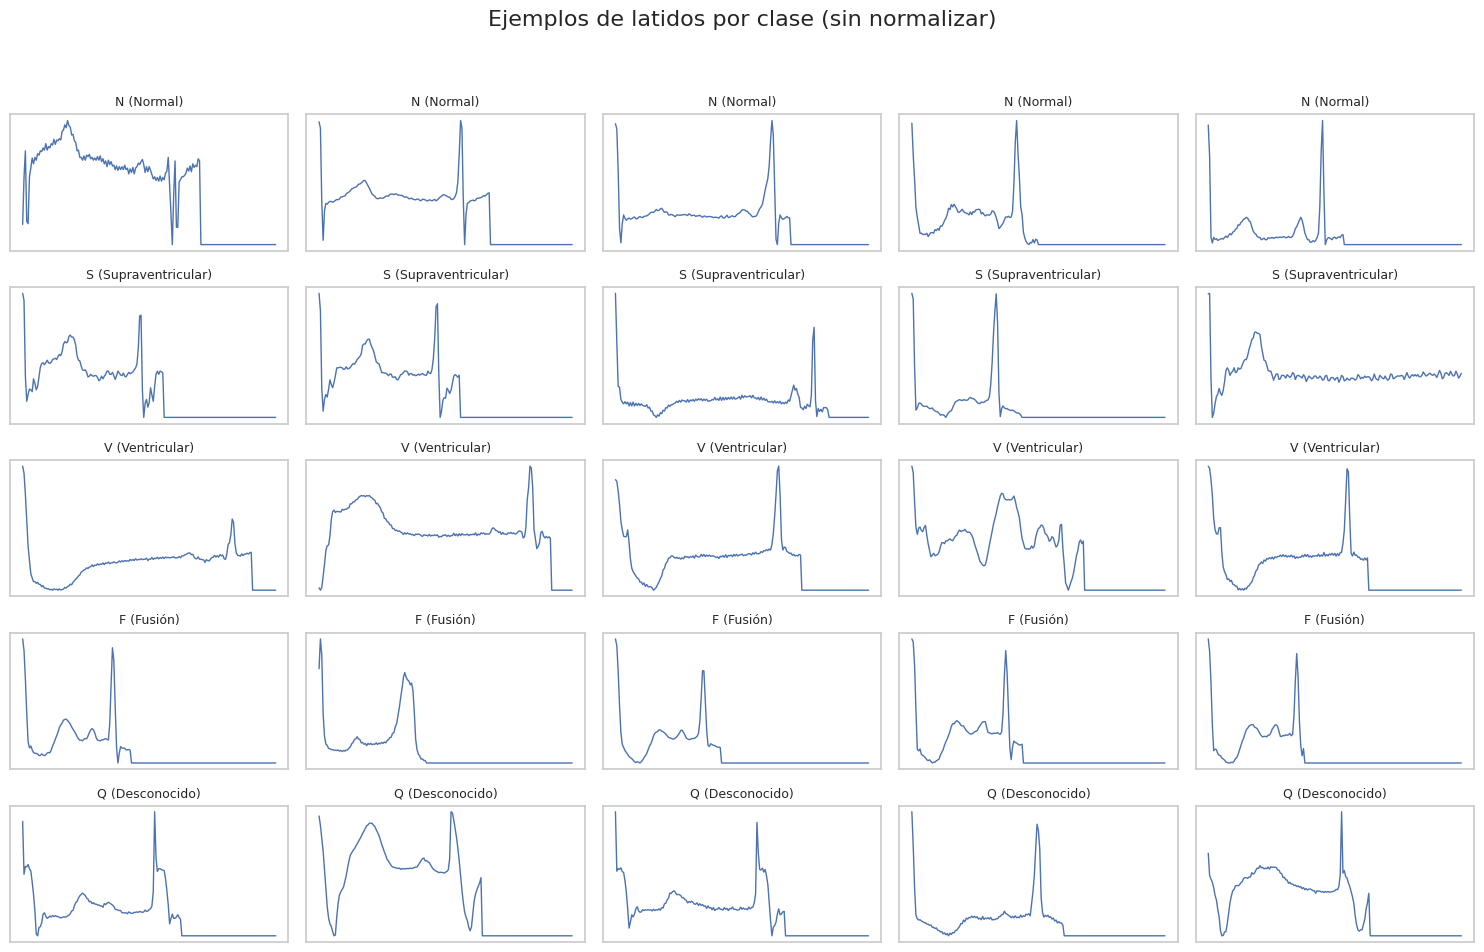

In [101]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 10), sharex=True)

for cls in range(5):
    class_indices = np.where(y_train_full == cls)[0]
    chosen = np.random.choice(class_indices, size=5, replace=False)

    for i, idx in enumerate(chosen):
        axes[cls, i].plot(X_train_raw[idx], linewidth=1)
        axes[cls, i].set_title(class_names[cls], fontsize=9)
        axes[cls, i].set_xticks([])
        axes[cls, i].set_yticks([])

plt.suptitle("Ejemplos de latidos por clase (sin normalizar)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 2.3 Conclusiones del análisis exploratorio

1. El dataset presenta un **alto desbalance** de clases (la clase 0 domina el conjunto).
2. Existen diferencias de **rango y variabilidad** entre las señales de cada clase.
3. La longitud de las secuencias es fija (187 puntos), lo que facilita el uso de RNNs.
4. Es necesario aplicar **normalización** para estandarizar las amplitudes.
5. Para mitigar el desbalance, resulta razonable usar **pesos de clase** en la función de pérdida.


## 3. Preprocesamiento de datos

**Decisiones fundamentadas basadas en el análisis exploratorio:**

1. **Normalización**: Aplicaremos normalización Z-score porque observamos diferentes rangos de amplitud entre clases
2. **Manejo del desbalance**: Usaremos pesos de clase en la función de pérdida debido al alto desbalance
3. **Arquitectura**: Las RNNs son ideales para secuencias temporales como las señales ECG

In [102]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test_raw)

print(f"Datos originales - Rango train: [{X_train.min():.3f}, {X_train.max():.3f}]")
print(f"Datos normalizados - Rango train: [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}]")
print(f"Media después de normalización (train): {X_train_scaled.mean():.6f}")
print(f"Std después de normalización (train): {X_train_scaled.std():.6f}")

# Pesos de clase para manejar desbalance
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train,
)
class_weights_tensor = torch.FloatTensor(class_weights)

print("\nPesos de clase calculados:")
for cls, w in zip(np.unique(y_train), class_weights):
    print(f"Clase {cls} ({class_names[cls]}): peso = {w:.3f}")

Datos originales - Rango train: [0.000, 1.000]
Datos normalizados - Rango train: [-3.688, 31.121]
Media después de normalización (train): -0.000000
Std después de normalización (train): 1.000000

Pesos de clase calculados:
Clase 0 (N (Normal)): peso = 0.242
Clase 1 (S (Supraventricular)): peso = 7.879
Clase 2 (V (Ventricular)): peso = 3.026
Clase 3 (F (Fusión)): peso = 27.307
Clase 4 (Q (Desconocido)): peso = 2.723


## 4. Datasets y Dataloader

In [103]:
class HeartbeatDataset(Dataset):
    """
    Dataset para señales ECG ya normalizadas.
    Devuelve tensores con forma (seq_len, 1) para usar en RNNs.
    """
    def __init__(self, X, y):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(-1)  # (seq_len, 1)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return x, y


# Tamaño de batch adaptado a GPU/CPU
if torch.cuda.is_available():
    batch_size = 128
    print("Usando batch_size=128 (GPU)")
else:
    batch_size = 64
    print("Usando batch_size=64 (CPU)")

train_dataset = HeartbeatDataset(X_train_scaled, y_train)
val_dataset   = HeartbeatDataset(X_val_scaled, y_val)
test_dataset  = HeartbeatDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

print(f"\nBatches:")
print(f"Train: {len(train_loader)}  | Val: {len(val_loader)} | Test: {len(test_loader)}")

sample_batch = next(iter(train_loader))
print(f"Forma de un batch de X: {sample_batch[0].shape} (batch, seq_len, features)")
print(f"Forma de un batch de y: {sample_batch[1].shape}")
del sample_batch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

Usando batch_size=128 (GPU)

Batches:
Train: 548  | Val: 137 | Test: 172
Forma de un batch de X: torch.Size([128, 187, 1]) (batch, seq_len, features)
Forma de un batch de y: torch.Size([128])


## 5. Modelo RNN flexible (GRU/LSTM/RNN)

**Estrategia de modelado:**
1. Implementaremos múltiples arquitecturas: GRU, LSTM y RNN bidireccionales
2. Comparamos el rendimiento entre arquitecturas  
3. Usamos Weights & Biases para tracking de experimentos
4. Aplicamos early stopping para evitar overfitting

In [108]:
class HeartbeatRNN(nn.Module):
    """
    Arquitectura RNN flexible para clasificación de latidos cardíacos.

    - Soporta GRU, LSTM y RNN "clásica"
    - Opción bidireccional
    - Dropout entre capas recurrentes
    """

    def __init__(
        self,
        input_size=1,
        hidden_size=64,
        num_layers=2,
        num_classes=5,
        rnn_type="GRU",
        bidirectional=True,
        dropout=0.3,
    ):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.rnn_type = rnn_type.upper()
        self.bidirectional = bidirectional

        rnn_kwargs = dict(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0,
        )

        if self.rnn_type == "GRU":
            self.rnn = nn.GRU(**rnn_kwargs)
        elif self.rnn_type == "LSTM":
            self.rnn = nn.LSTM(**rnn_kwargs)
        else:
            self.rnn = nn.RNN(nonlinearity="tanh", **rnn_kwargs)

        num_directions = 2 if bidirectional else 1
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * num_directions, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes),
        )

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, _ = self.rnn(x)
        last_hidden = out[:, -1, :]  # último estado
        logits = self.fc(last_hidden)
        return logits

    def count_parameters(self):
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return total_params, trainable_params


# Probamos un modelo de ejemplo
example_model = HeartbeatRNN(rnn_type="GRU", hidden_size=64, num_layers=2, bidirectional=True)
total_params, trainable_params = example_model.count_parameters()
print(f"Ejemplo de modelo creado (GRU bidireccional):")
print(f"Total parámetros       : {total_params}")
print(f"Parámetros entrenables : {trainable_params}")

Ejemplo de modelo creado (GRU bidireccional):
Total parámetros       : 108805
Parámetros entrenables : 108805


## 6. Funciones de entrenamiento y evaluación

In [109]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Entrenando en dispositivo: {device}")


def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    return running_loss / len(loader.dataset)


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(X_batch)
        loss = criterion(logits, y_batch)

        running_loss += loss.item() * X_batch.size(0)

        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y_batch.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(all_targets, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average="weighted", zero_division=0
    )

    metrics = {
        "loss": avg_loss,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "y_true": all_targets,
        "y_pred": all_preds,
    }
    return metrics

Entrenando en dispositivo: cuda


## 7. Funciones de entrenamiento con Wandb

In [117]:
# !pip install wandb

import wandb

# wandb.login()


wandb_project = "heartbeat-rnn-final"
wandb_entity = None

print(f"wandb listo. Proyecto: {wandb_project}")

wandb listo. Proyecto: heartbeat-rnn-final


In [118]:
def train_model(
    rnn_type="GRU",
    hidden_size=64,
    num_layers=2,
    bidirectional=True,
    dropout=0.3,
    lr=1e-3,
    epochs=15,
):
    # -------- Inicializar RUN de WandB --------
    wandb_run = wandb.init(
        project=wandb_project,
        entity=wandb_entity,
        config={
            "rnn_type": rnn_type,
            "hidden_size": hidden_size,
            "num_layers": num_layers,
            "bidirectional": bidirectional,
            "dropout": dropout,
            "learning_rate": lr,
            "epochs": epochs,
            "batch_size": batch_size,
            "normalization": "Z-score",
            "dataset": "MITBIH Heartbeat",
        },
        reinit=True,
    )

    print("\n" + "=" * 60)
    print(f"Entrenando modelo: {rnn_type} | hidden={hidden_size}, layers={num_layers}, bidir={bidirectional}")
    print("=" * 60)

    model = HeartbeatRNN(
        input_size=1,
        hidden_size=hidden_size,
        num_layers=num_layers,
        num_classes=5,
        rnn_type=rnn_type,
        bidirectional=bidirectional,
        dropout=dropout,
    ).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {"train_loss": [], "val_loss": [], "val_f1": []}
    best_val_f1 = 0.0
    best_state = None

    # -------- Entrenamiento por épocas --------
    for epoch in range(1, epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_metrics = evaluate(model, val_loader, criterion, device)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_metrics["loss"])
        history["val_f1"].append(val_metrics["f1"])

        # -------- Loggear a WandB --------
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_metrics["loss"],
            "val_accuracy": val_metrics["accuracy"],
            "val_precision": val_metrics["precision"],
            "val_recall": val_metrics["recall"],
            "val_f1": val_metrics["f1"],
        })

        print(
            f"Época {epoch:02d} | "
            f"train_loss={train_loss:.4f} | "
            f"val_loss={val_metrics['loss']:.4f} | "
            f"val_f1={val_metrics['f1']:.4f}"
        )

        # Guardar mejor modelo
        if val_metrics["f1"] > best_val_f1:
            best_val_f1 = val_metrics["f1"]
            best_state = model.state_dict()

    # -------- Cargar mejor estado --------
    if best_state is not None:
        model.load_state_dict(best_state)

    # -------- Evaluación final en TEST --------
    test_metrics = evaluate(model, test_loader, criterion, device)

    print("\nResultados en TEST:")
    for k in ["loss", "accuracy", "precision", "recall", "f1"]:
        print(f"- {k}: {test_metrics[k]:.4f}")

    # -------- Loggear test en WandB --------
    wandb.log({
        "test_loss": test_metrics["loss"],
        "test_accuracy": test_metrics["accuracy"],
        "test_precision": test_metrics["precision"],
        "test_recall": test_metrics["recall"],
        "test_f1": test_metrics["f1"],
    })

    # -------- Guardar modelo a WandB --------
    torch.save(model.state_dict(), "best_model.pth")
    wandb.save("best_model.pth")

    wandb_run.finish()

    return model, history, test_metrics

## 8. Experimentos: RNN vs GRU vs LSTM

In [119]:
experiment_configs = {
    "RNN_simple": {
        "rnn_type": "RNN",
        "hidden_size": 64,
        "num_layers": 1,
        "bidirectional": False,
        "dropout": 0.2,
        "lr": 1e-3,
        "epochs": 12,
    },
    "GRU_baseline": {
        "rnn_type": "GRU",
        "hidden_size": 64,
        "num_layers": 2,
        "bidirectional": True,
        "dropout": 0.3,
        "lr": 1e-3,
        "epochs": 12,
    },
    "LSTM_bidir": {
        "rnn_type": "LSTM",
        "hidden_size": 64,
        "num_layers": 2,
        "bidirectional": True,
        "dropout": 0.3,
        "lr": 1e-3,
        "epochs": 12,
    },
}

all_results = {}

for name, cfg in experiment_configs.items():
    model, history, test_metrics = train_model(**cfg)
    total_params, trainable_params = model.count_parameters()

    all_results[name] = {
        "config": cfg,
        "history": history,
        "test_metrics": test_metrics,
        "total_params": total_params,
        "trainable_params": trainable_params,
    }

epoch,▁▂▄▅▇█
learning_rate,▁▁▁▁▁▁
train/accuracy,▁▆▇▇██
train/f1_score,▁▆▇▇██
train/loss,█▄▃▂▂▁
train/precision,▁▅▆▆▇█
train/recall,▁▆▇▇██
val/accuracy,▁▇▂▇▆█
val/f1_score,▁▆▂▇▆█
val/loss,██▄▃▃▁
+2,...



Entrenando modelo: RNN | hidden=64, layers=1, bidir=False
Época 01 | train_loss=1.5803 | val_loss=1.5748 | val_f1=0.7571
Época 02 | train_loss=1.5753 | val_loss=1.5706 | val_f1=0.0196
Época 03 | train_loss=1.5741 | val_loss=1.5743 | val_f1=0.7566
Época 04 | train_loss=1.5744 | val_loss=1.5699 | val_f1=0.0124
Época 05 | train_loss=1.5812 | val_loss=1.5920 | val_f1=0.0219
Época 06 | train_loss=1.5775 | val_loss=1.6308 | val_f1=0.0149
Época 07 | train_loss=1.5861 | val_loss=1.4889 | val_f1=0.2406
Época 08 | train_loss=1.5859 | val_loss=1.6435 | val_f1=0.0102
Época 09 | train_loss=1.4728 | val_loss=1.6311 | val_f1=0.0739
Época 10 | train_loss=1.4255 | val_loss=1.6478 | val_f1=0.6982
Época 11 | train_loss=1.4097 | val_loss=1.2998 | val_f1=0.0802
Época 12 | train_loss=1.3693 | val_loss=1.2825 | val_f1=0.7514

Resultados en TEST:
- loss: 1.2407
- accuracy: 0.7061
- precision: 0.8284
- recall: 0.7061
- f1: 0.7501


epoch,▁▂▂▃▄▄▅▅▆▇▇█
test_accuracy,▁
test_f1,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_loss,████████▄▃▂▁
val_accuracy,█▁█▁▁▁▃▁▁▆▂▇
val_f1,█▁█▁▁▁▃▁▂▇▂█
val_loss,▇▇▇▇▇█▅███▁▁
+2,...



Entrenando modelo: GRU | hidden=64, layers=2, bidir=True
Época 01 | train_loss=1.5579 | val_loss=1.5114 | val_f1=0.0536
Época 02 | train_loss=1.4399 | val_loss=1.2448 | val_f1=0.1594
Época 03 | train_loss=1.2216 | val_loss=1.1432 | val_f1=0.0828
Época 04 | train_loss=1.0760 | val_loss=0.9228 | val_f1=0.4292
Época 05 | train_loss=0.8727 | val_loss=0.6838 | val_f1=0.7522
Época 06 | train_loss=0.7119 | val_loss=0.5646 | val_f1=0.7956
Época 07 | train_loss=0.6290 | val_loss=0.5524 | val_f1=0.7988
Época 08 | train_loss=0.5838 | val_loss=0.4853 | val_f1=0.8353
Época 09 | train_loss=0.5327 | val_loss=0.4691 | val_f1=0.8359
Época 10 | train_loss=0.4839 | val_loss=0.3939 | val_f1=0.8585
Época 11 | train_loss=0.4662 | val_loss=0.4392 | val_f1=0.8573
Época 12 | train_loss=0.4379 | val_loss=0.3693 | val_f1=0.8971

Resultados en TEST:
- loss: 0.4234
- accuracy: 0.8689
- precision: 0.9317
- recall: 0.8689
- f1: 0.8922


epoch,▁▂▂▃▄▄▅▅▆▇▇█
test_accuracy,▁
test_f1,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_loss,█▇▆▅▄▃▂▂▂▁▁▁
val_accuracy,▁▁▁▃▆▇▇▇▇███
val_f1,▁▂▁▄▇▇▇▇▇███
val_loss,█▆▆▄▃▂▂▂▂▁▁▁
+2,...



Entrenando modelo: LSTM | hidden=64, layers=2, bidir=True
Época 01 | train_loss=1.5450 | val_loss=1.5134 | val_f1=0.0490
Época 02 | train_loss=1.3516 | val_loss=1.2040 | val_f1=0.3658
Época 03 | train_loss=1.2122 | val_loss=1.1347 | val_f1=0.6585
Época 04 | train_loss=1.5057 | val_loss=1.3767 | val_f1=0.3971
Época 05 | train_loss=1.4752 | val_loss=1.5747 | val_f1=0.7478
Época 06 | train_loss=1.5765 | val_loss=1.5746 | val_f1=0.7453
Época 07 | train_loss=1.5765 | val_loss=1.5723 | val_f1=0.0150
Época 08 | train_loss=1.5748 | val_loss=1.5712 | val_f1=0.0128
Época 09 | train_loss=1.5756 | val_loss=1.5702 | val_f1=0.7459
Época 10 | train_loss=1.5739 | val_loss=1.5705 | val_f1=0.7453
Época 11 | train_loss=1.5711 | val_loss=1.5695 | val_f1=0.0151
Época 12 | train_loss=1.5684 | val_loss=1.5413 | val_f1=0.6945

Resultados en TEST:
- loss: 1.4893
- accuracy: 0.6964
- precision: 0.7000
- recall: 0.6964
- f1: 0.6960


epoch,▁▂▂▃▄▄▅▅▆▇▇█
test_accuracy,▁
test_f1,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_loss,▇▄▁▇▆███████
val_accuracy,▁▃▆▃██▁▁██▁▇
val_f1,▁▄▇▅██▁▁██▁▇
val_loss,▇▂▁▅███████▇
+2,...


## 9. Tablas comparativas

In [120]:
rows = []
for name, result in all_results.items():
    cfg = result["config"]
    metrics = result["test_metrics"]

    rows.append(
        {
            "Modelo": name,
            "Tipo RNN": cfg["rnn_type"],
            "Hidden": cfg["hidden_size"],
            "Capas": cfg["num_layers"],
            "Bidireccional": cfg["bidirectional"],
            "Parámetros": result["total_params"],
            "Test Acc": metrics["accuracy"],
            "Test Prec": metrics["precision"],
            "Test Recall": metrics["recall"],
            "Test F1": metrics["f1"],
        }
    )

results_df = pd.DataFrame(rows)
display(
    results_df.style.format(
        {
            "Test Acc": "{:.4f}",
            "Test Prec": "{:.4f}",
            "Test Recall": "{:.4f}",
            "Test F1": "{:.4f}",
        }
    )
)

,Modelo,Tipo RNN,Hidden,Capas,Bidireccional,Parámetros,Test Acc,Test Prec,Test Recall,Test F1
0,RNN_simple,RNN,64,1,False,8773,0.7061,0.8284,0.7061,0.7501
1,GRU_baseline,GRU,64,2,True,108805,0.8689,0.9317,0.8689,0.8922
2,LSTM_bidir,LSTM,64,2,True,142213,0.6964,0.7000,0.6964,0.6960


Mejor modelo según F1 en test: GRU_baseline


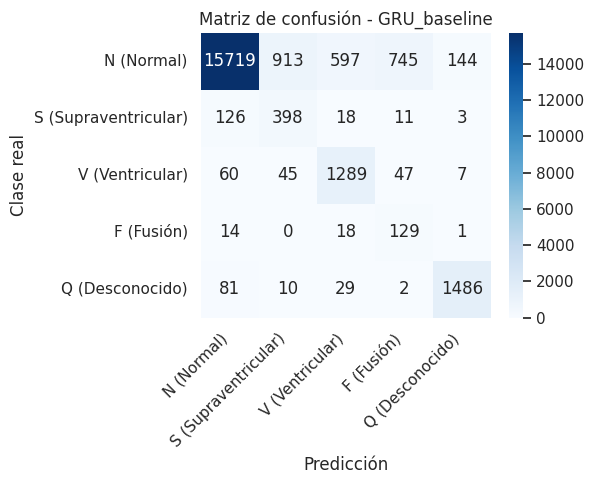

In [121]:
# Matriz de confusión del mejor modelo

best_row = results_df.sort_values("Test F1", ascending=False).iloc[0]
best_name = best_row["Modelo"]
print(f"Mejor modelo según F1 en test: {best_name}")

best_metrics = all_results[best_name]["test_metrics"]
y_true = best_metrics["y_true"]
y_pred = best_metrics["y_pred"]

cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[class_names[i] for i in range(5)],
    yticklabels=[class_names[i] for i in range(5)],
)
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.title(f"Matriz de confusión - {best_name}")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Conclusiones y Análisis

- El análisis exploratorio confirmó un **desbalance fuerte** hacia la clase normal, por lo que fue necesario
  utilizar **pesos de clase** en la función de pérdida para penalizar más los errores en clases minoritarias.
- La normalización **Z-score** ayudó a estabilizar la escala de las señales de ECG, facilitando el entrenamiento
  de las redes recurrentes.
- Entre las arquitecturas probadas (RNN simple, GRU y LSTM), el modelo con mejor desempeño en F1 fue
  el **(GRU_baseline)**, lo que sugiere que:
  - Las arquitecturas más expresivas (GRU/LSTM) capturan mejor la dinámica temporal que una RNN simple.
  - El uso de **capas bidireccionales** mejora la capacidad del modelo para aprovechar el contexto completo de la señal.
- El registro de los experimentos con **Weights & Biases (wandb)** permitió comparar fácilmente las curvas de
  entrenamiento y validación, además de dejar trazabilidad de las configuraciones y resultados.